In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [36]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')

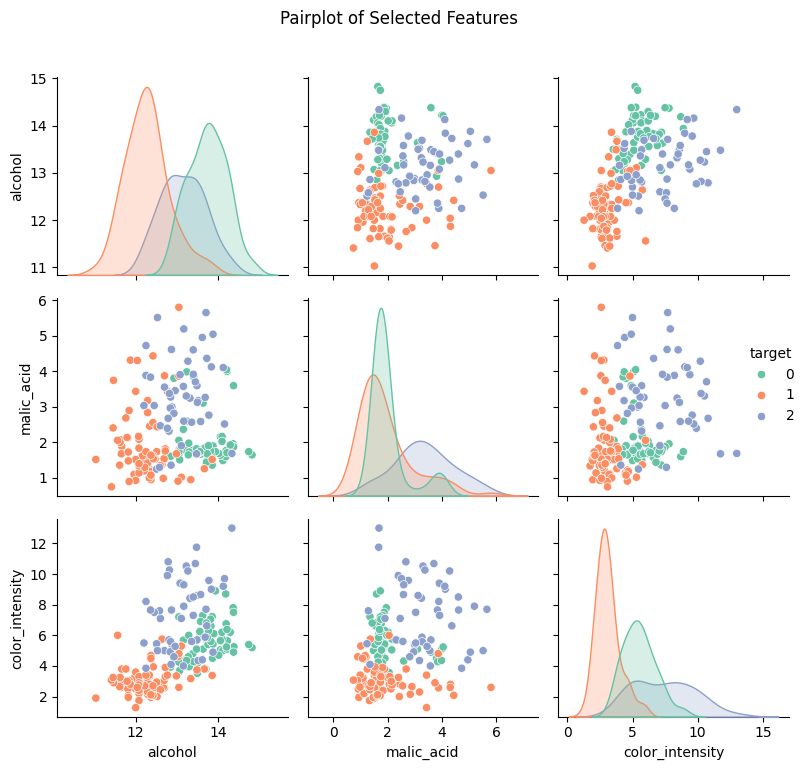

In [37]:
sns.pairplot(pd.concat([X[['alcohol', 'malic_acid', 'color_intensity']], y], axis=1), hue='target', palette='Set2')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.tight_layout()
plt.show()

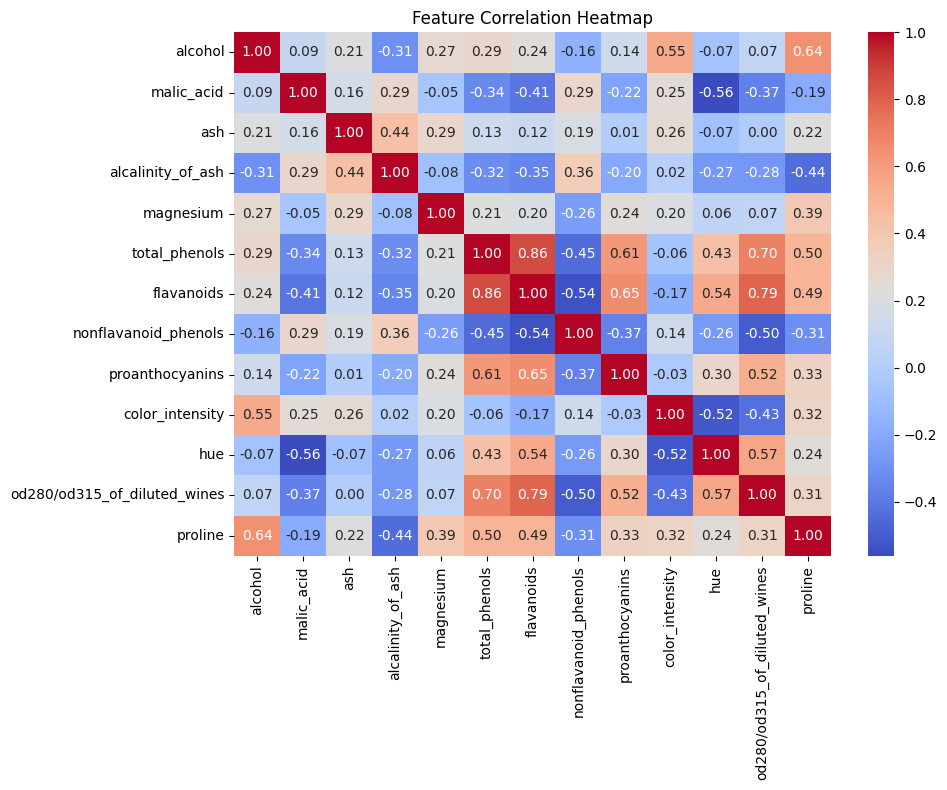

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

In [41]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    
    def forward(self, x):
        return self.net(x)

model = Classifier()

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_dl))

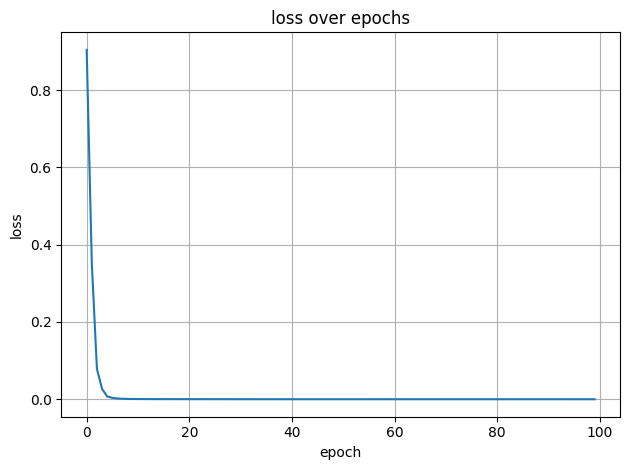

In [48]:
plt.figure()
plt.plot(losses)
plt.title("loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1)

print(classification_report(y_test, y_pred.numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



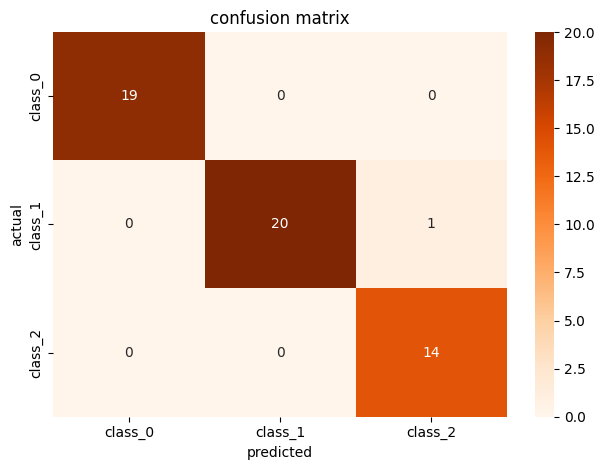

In [45]:
conf_matrix = confusion_matrix(y_test, y_pred.numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.tight_layout()
plt.show()

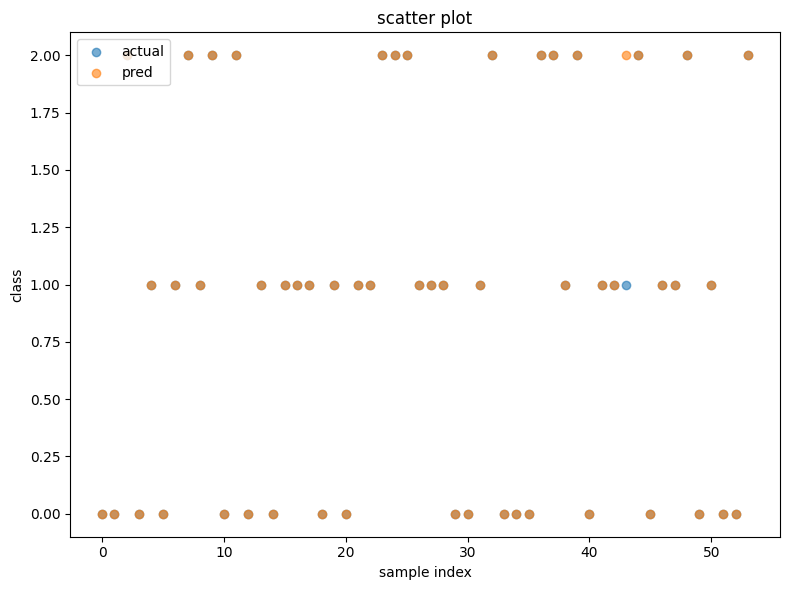

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label='actual', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred.numpy(), label='pred', alpha=0.6)
plt.title("scatter plot")
plt.xlabel("sample index")
plt.ylabel("class")
plt.legend()
plt.tight_layout()
plt.show()